In [1]:
import os, sys
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Merge, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import SGD, Adam, Adamax
from keras.models import model_from_yaml
from keras.regularizers import l1, l2
from load_dataset import get_data, dataset
from utils import print_metadata, get_dgaze_frames_count, split_data, plot_gaze_points, save_model, load_model

from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import copy
import cv2 

from numpy.random import seed
seed(3)

from tensorflow import set_random_seed
set_random_seed(2)

import random 
random.seed(1)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# from keras import backend as k
# import tensorflow as tf
# config = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1,
# allow_soft_placement=True, device_count = {'CPU': 1})
# sess = tf.Session(graph=tf.get_default_graph(),config=config)
# k.set_session(sess)

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
data_path = '/ssd_scratch/cvit/isha/eye_gaze_mapping/DGM_final2/dataset_samples_callibrated/'
model_save = '/ssd_scratch/cvit/isha/DGAZE2/DGAZE_weights/weights_lefteye'
drivers = os.listdir(data_path)
ndrivers = len(drivers)
sequences = 112

# Driver_data is dict contatining drivers user1, user 2.....etc. For each driver, we have 112 sequences and for   
# each sequence we have features like ['face_location', 'headpose_pupil', 'left_eye', 'gaze_point', 'right_eye'] 
driver_data = get_data(data_path, drivers, sequences)

# Print the total numer of frames in the dataset
get_dgaze_frames_count(driver_data, drivers)

# Prints the DGAZE Metadata including list of drivers, sequences and features 
#print_metadata(driver_data, ['drivers', 'sequences', 'features'])
print_metadata(driver_data, ['features'])

100%|██████████| 20/20 [00:17<00:00,  1.09it/s]


Total frames in DGAZE dataset is 227178
List of Features: ['face_location', 'gaze_point', 'headpose_pupil', 'left_eye', 'right_eye']



In [3]:
seq_range = np.arange(10, sequences+1)
nsequences = len(seq_range)
ndrivers = len(drivers)
random.shuffle(drivers)

dsplit = [int(0.8*ndrivers),int(0.1*ndrivers), int(0.1*ndrivers)]
gp_split = [int(0.6*nsequences),int(0.2*nsequences), int(0.2*nsequences)]
data_split = split_data(drivers, seq_range, dsplit, gp_split)

In [4]:
data_split

{'drivers_test': ['user19', 'user21'],
 'drivers_train': ['user23',
  'user22',
  'user16',
  'user18',
  'user8',
  'user15',
  'user5',
  'user17',
  'user20',
  'user12',
  'user10',
  'user7',
  'user24',
  'user13',
  'user11',
  'user14'],
 'drivers_val': ['user2', 'user3'],
 'sequence_test': array([ 66,  38,  77, 109,  64,  37,  97,  58,  11,  79,  93, 104,  12,
         13,  50,  23,  85,  39, 102,  44]),
 'sequence_train': array([ 24,  56,  81,  46, 106, 111,  94,  27,  14,  61, 110,  86, 105,
         18,  98,  90,  48,  10,  17,  26,  31,  51,  30,  89,  87,  71,
         72,  96,  32,  19,  49,  62, 112,  84,  60,  59,  43,  20,  16,
         69, 107,  15,  55,  53,  45, 100,  21,  76,  36,  65,  57, 101,
         40,  82,  70,  35,  42,  75,  41,  91,  78]),
 'sequence_val': array([ 28,  29,  34,  95,  74,  52,  25,  83,  33,  22,  63, 103,  47,
         68,  92,  88,  54, 108,  80,  73])}

In [5]:
# Training dataset
train = dataset(driver_data, data_split['drivers_train'], data_split['sequence_train'])

# Validation dataset
val = dataset(driver_data, data_split['drivers_val'], data_split['sequence_val'])

# Test dataset
test = dataset(driver_data, data_split['drivers_test'], data_split['sequence_test'])

100%|██████████| 2/2 [00:00<00:00,  5.65it/s]


In [6]:
print(train['left_eye'].shape, train['right_eye'].shape, train['headpose_pupil'].shape, \
      train['face_location'].shape, train['face_features'].shape, train['gaze_point'].shape)

print(val['left_eye'].shape, val['right_eye'].shape, val['headpose_pupil'].shape, \
      val['face_location'].shape, val['face_features'].shape, val['gaze_point'].shape)

print(test['left_eye'].shape, test['right_eye'].shape, test['headpose_pupil'].shape, \
      test['face_location'].shape, test['face_features'].shape, test['gaze_point'].shape)

print("Total number of frames -->",train['gaze_point'].shape[0] + val['gaze_point'].shape[0]\
      + test['gaze_point'].shape[0])

(100252, 36, 60, 3) (100252, 36, 60, 3) (100252, 11) (100252, 4) (100252, 14) (100252, 6)
(4656, 36, 60, 3) (4656, 36, 60, 3) (4656, 11) (4656, 4) (4656, 14) (4656, 6)
(3595, 36, 60, 3) (3595, 36, 60, 3) (3595, 11) (3595, 4) (3595, 14) (3595, 6)
Total number of frames --> 108503


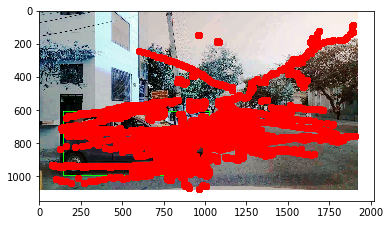

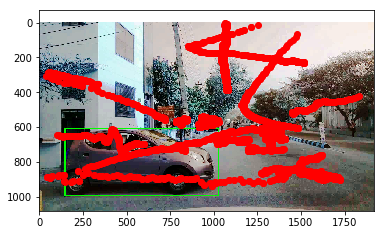

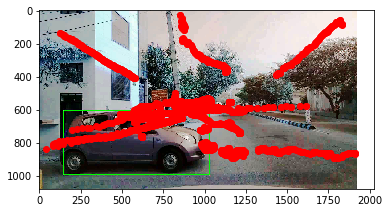

In [7]:
plot_gaze_points(data_path, train['gaze_point'])
plot_gaze_points(data_path, val['gaze_point'])
plot_gaze_points(data_path, test['gaze_point'])

100%|██████████| 1/1 [00:00<00:00, 326.28it/s]


[5.33693600e+00 4.13006830e+00 1.12720594e+01 3.61000000e+02
 4.54000000e+02 2.02000000e+02 4.57000000e+02 9.57760000e+04
 2.67000000e+02 5.58000000e+02 2.48000000e+02 7.69000000e+02
 3.40000000e+01 5.55000000e+02]


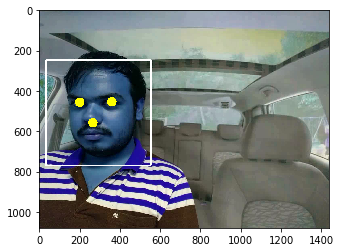

100%|██████████| 1/1 [00:00<00:00, 333.20it/s]


[-8.22075069e-01 -1.70922029e+00  6.99065304e+00  3.30000000e+02
  4.48000000e+02  1.82000000e+02  4.57000000e+02  1.01136000e+05
  2.32000000e+02  5.84000000e+02  2.33000000e+02  8.18000000e+02
  0.00000000e+00  5.61000000e+02]


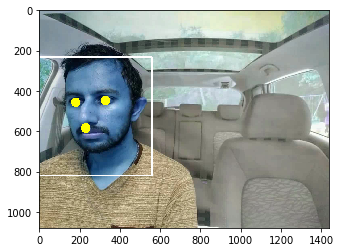

In [8]:
for d in data_split['drivers_val']:
    data_calibrate = dataset(driver_data, [d], np.arange(12,13))
    x = data_calibrate['face_location']
    y = data_calibrate['headpose_pupil']
    print(data_calibrate['face_features'][0])

    cap = cv2.VideoCapture(data_path + d + '/driver_view/sample_10.avi')
    ret, frame = cap.read()
    plt.figure()
    cv2.rectangle(frame, (x[0,2], x[0,0]), (x[0,3], x[0,1]), (255, 255, 255), 6)
    cv2.circle(frame,(int(y[0,6]), int(y[0,7])),3,(255,255,0),40)
    cv2.circle(frame,(int(y[0,4]), int(y[0,5])),3,(255,255,0),40)
    cv2.circle(frame,(int(y[0,9]), int(y[0,10])),3,(255,255,0),40)
    plt.imshow(frame)
    plt.show()

In [9]:
# scaler = preprocessing.MinMaxScaler()
# train['face_features'] = scaler.fit_transform(train['face_features'])
# val['face_features'] = scaler.transform(val['face_features'])
# test['face_features'] = scaler.transform(test['face_features'])


In [10]:
train['left_eye'].max()

1.0

In [ ]:
model_lefteye = Sequential()
model_lefteye.add(Conv2D(20, kernel_size=(3, 3),activation='relu',input_shape=(36,60,3)))
model_lefteye.add(MaxPooling2D(pool_size=(2, 2)))

model_lefteye.add(Conv2D(50, (3, 3), activation='relu'))
model_lefteye.add(MaxPooling2D(pool_size=(2, 2)))
model_lefteye.add(Flatten())


# model_facefeatures = Sequential()
# model_facefeatures.add(Dense(16, activation ='relu', input_dim=(14)))

# model_merge = Sequential()
# model_merge.add(Merge([model_lefteye, model_facefeatures], mode = 'concat'))
model_merge = model_lefteye
model_merge.add(Dense(512, activation='relu'))
#model_merge.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model_merge.add(Dense(2, activation="linear"))
print(model_merge.summary())

In [ ]:
opt = Adam(lr=0.001, decay=0.1 / 200)
model_merge.compile(loss = 'mae', optimizer = opt )
earlystopping = keras.callbacks.EarlyStopping(monitor = 'val_loss',min_delta = 1, patience =2, verbose =0, mode ='auto')

history = model_merge.fit([train['left_eye']], train['gaze_point'][:,:2], \
                validation_data= ([val['left_eye']],val['gaze_point'][:,:2]),
                epochs = 200, batch_size = 32,  verbose=1, shuffle= True)

save_model(model_save, model_merge)

print(history.history.keys())

In [ ]:
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.show()

In [ ]:
def gaze_error(model, data):
    scores = model.evaluate([data['left_eye']], data['gaze_point'][:,:2])
    return scores


In [ ]:
# model_merge = load_model(model_save)
# model_merge.compile(loss='mae', optimizer=opt)

train_error = gaze_error(model_merge, train)
val_error = gaze_error(model_merge, val)
test_error = gaze_error(model_merge, test)
    
print("Train Error ==> ", train_error)
print("Val Error ==> ",  val_error)
print("Test Error ==> " ,test_error)

In [ ]:
te_error = 0
for driver in data_split['drivers_test']:
    data_calibrate = dataset(driver_data, [driver],np.arange(1,15))                         
    te_calibrate = test
       
    opt = Adam(lr=0.001, decay=0.1 / 200)
    model_merge.load_weights(model_save + ".h5")
    model_merge.compile(loss = 'mae', optimizer = opt)
  
    
    error_before = gaze_error(model_merge, te_calibrate)
    print("Before calibration error ==> " ,error_before)
                         
    model_merge.fit([data_calibrate['left_eye']], data_calibrate['gaze_point'][:,:2], \
                validation_data= ([te_calibrate['left_eye']],te_calibrate['gaze_point'][:,:2]),
                epochs = 10, batch_size = 32,verbose=1, shuffle= True)


    error_after = gaze_error(model_merge, te_calibrate)
    te_error += error_after
    print("After calibration error ==> " ,error_after)
                         
print("Total test error -->", te_error/len(data_split['drivers_test']))
                         
    